# Informes de la comunidad de Madrid

Actualizado diariamente, este documento se [visualiza mejor aquí](https://nbviewer.jupyter.org/github/jaimevalero/COVID-19/blob/master/jupyter/Madrid_Pain_Graphs.ipynb).

Datos de la situación de la infección por coronavirus en la Comunidad de Madrid.

Nos descargamos los datos, agrupamos, y calculamos :

- Gráfico de seguimiento.


- Muertes medias diarias, últimos 7 días.


- Muertes medias diarias desde que la comunidad de Madrid publica datos.



In [1]:
# Miramos si hay nuevos datos a descargar.

!# cd ../data/; FILELIST=" 200509 200508 200507 200506 200505 200504 200503 200502 200501 200430 200429 200428 200427 200426 200425 200424 200423 200422 200510 200511 200512 200513 200514 200515 200516 200517 200518 200519 200520 200521 200522 200523 200524 200525 200526 200527 200528 200529 200530 200609 200608 200607 200606 200605 200604 200603 200602 200601 200610 200611 200612 200613 200614 200615 200616 200617 200618 200619 200620 200621 200622 200623 200624 200625 200626 200627 200628 200629 200630 " ; for fecha in `echo $FILELIST`  ; do  FILE=${fecha}_cam_covid19.pdf ;  [ ! -f ../data/${FILE} ] && echo $FILE:::::    && wget https://www.comunidad.madrid/sites/default/files/doc/sanidad/$FILE 1>/dev/null  2>/dev/null && ls -altr $FILE ; done 

# Miramos solo hoy y los ultimos diez dias
! cd ../data/; FILELIST=`seq -w 0 10 | while read i ; do date +%y%m%d -d "$i day ago" ; done` ; for fecha in `echo $FILELIST`  ; do  FILE=${fecha}_cam_covid19.pdf ;  [ ! -f ../data/${FILE} ] && echo $FILE:::::    && wget https://www.comunidad.madrid/sites/default/files/doc/sanidad/$FILE 1>/dev/null  2>/dev/null && ls -altr $FILE ; done 
! cd ../data/; FILELIST=`seq -w 0 10 | while read i ; do date +%y%m%d -d "$i day ago" ; done` ; for fecha in `echo $FILELIST`  ; do  FILE=${fecha}cam_covid19.pdf ;  [ ! -f ../data/${FILE} ] && echo $FILE:::::    && wget https://www.comunidad.madrid/sites/default/files/doc/sanidad/$FILE 1>/dev/null  2>/dev/null && ls -altr $FILE ; done 


200809_cam_covid19.pdf:::::
200808_cam_covid19.pdf:::::
200803_cam_covid19.pdf:::::
200802_cam_covid19.pdf:::::
200801_cam_covid19.pdf:::::
200811cam_covid19.pdf:::::
200810cam_covid19.pdf:::::
200809cam_covid19.pdf:::::
200808cam_covid19.pdf:::::
200807cam_covid19.pdf:::::
200806cam_covid19.pdf:::::
200805cam_covid19.pdf:::::
200804cam_covid19.pdf:::::
200802cam_covid19.pdf:::::
200801cam_covid19.pdf:::::


In [2]:
from tabula import read_pdf
from IPython.display import display, HTML
import os 
import pandas as pd
import glob 
import re 
from tqdm.notebook import tqdm
import warnings
import os.path

warnings.filterwarnings('ignore')


os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-openjdk-1.8.0.141-1.b16.el7_3.x86_64/jre"

# Auxiliary functions
from datetime import datetime, date, time, timedelta

""" Rellenar dias vacios con interpolacion"""
def interpolate_dataframe(df,freq):
    if freq == 'H':
        rng = pd.date_range(df.index.min(), df.index.max() + pd.Timedelta(23, 'H'), freq='H')
    elif freq == 'D' :  
        rng = pd.date_range(
                        datetime.strptime(str(df.index.min())[:10]+' 00:00:00', "%Y-%m-%d %H:%M:%S") ,
                        datetime.strptime(str(df.index.max())[:10]+' 00:00:00', "%Y-%m-%d %H:%M:%S"), 
                        freq='D')
        df.index = pd.to_datetime(df.index)  
    df2 = df.reindex(rng)
    df = df2
    for column in df.columns :
        s = pd.Series(df[column])
        s.interpolate(method="quadratic", inplace =True)
        df[column] = pd.DataFrame([s]).T
    return df

def fet_daily_date_new_format(fecha): 
    
    file_path = '../data/'+fecha+'_cam_covid19.pdf'
    if not os.path.isfile(file_path):
        file_path = '../data/'+fecha+'cam_covid19.pdf'
    #print("Analizando:" + file_path)
    df_pdf =  read_pdf(file_path,area=(000, 600, 400, 800) , pages='1')
        
    
    df = df_pdf[0]
    df = df['Unnamed: 0'].astype(str).str.replace(r".", '').replace("(", ' ')
    df = df.T
    df.columns = df.iloc[0]
    df = df.iloc[1:]


    df = pd.DataFrame(data=df)
    df    

    dict = {}
    dict['HOSPITALES'] = df[df['Unnamed: 0'].str.contains('Hospitales')].iloc[0]['Unnamed: 0'].split(' ')[0]
    dict['DOMICILIOS'] = df[df['Unnamed: 0'].str.contains('Domicilios')].iloc[0]['Unnamed: 0'].split(' ')[0]
    dict['CENTROS SOCIOSANITARIOS'] = df[df['Unnamed: 0'].str.contains('Centros')].iloc[0]['Unnamed: 0'].split(' ')[0]
    dict['OTROS LUGARES'] = df[df['Unnamed: 0'].str.contains('otros')].iloc[0]['Unnamed: 0'].split(' ')[0]

    cadena_a_parsear = df[df['Unnamed: 0'].str.contains('otal')].iloc[0]['Unnamed: 0']

    dict['FALLECIDOS TOTALES'] = re.search(r'(\d+)', cadena_a_parsear)[0]

    df = pd.DataFrame.from_dict(dict, orient='index').T
    df['Fecha'] =  pd.to_datetime(fecha, format='%y%m%d')
    df.set_index('Fecha', inplace=True, drop=True)
    return df


def get_daily_data(fecha):
    if fecha > '200512' : 
        return fet_daily_date_new_format(fecha)
    
    col2str = {'dtype': str}
    kwargs = {'output_format': 'dataframe',
              'pandas_options': col2str,
              'stream': True}
    df_pdf =  read_pdf('../data/'+fecha+'_cam_covid19.pdf',pages='1',multiple_tables = True,**kwargs)

    
    df = df_pdf[0]

    df = df[df['Unnamed: 0'].notna()]
    df = df[(df['Unnamed: 0']=='HOSPITALES') | (df['Unnamed: 0'] == 'DOMICILIOS') | (df['Unnamed: 0'] == 'CENTROS SOCIOSANITARIOS') | (df['Unnamed: 0'] == 'OTROS LUGARES') | (df['Unnamed: 0'] == 'FALLECIDOS TOTALES')]
    df = df[['Unnamed: 0','Unnamed: 2']]
    df['Unnamed: 2'] = df['Unnamed: 2'].astype(str).str.replace(r".", '')
    df = df.T
    df.columns = df.iloc[0]
    df = df.iloc[1:]

    df['Fecha'] =  pd.to_datetime(fecha, format='%y%m%d')
    df = df.rename_axis(None)

    df.set_index('Fecha', inplace=True, drop=True)
    df.index
    df.dropna()
    #df = df.T
    return df

def get_all_data( ): 
    #BLACKLIST = ["200429","200422"]
    #BLACKLIST = ["200514",]
    BLACKLIST = []
    df = pd.DataFrame()
    list_df = []
 
    pdf_list= sorted(glob.glob('../data/*_covid19.pdf'), 
                     key=os.path.getmtime,
                     reverse=True )
    
    #for pdf_file in pdf_list:
        
    for pdf_file in tqdm(pdf_list, 
                         desc="Procesando pdfs diarios"):   
        # extract fecha from username , eg : ../data/2200422_cam_covid19.pdf
        fecha = pdf_file.split('/')[2].split('_')[0].replace('cam_','').replace('_cam_','').replace('cam','')
        if fecha not in BLACKLIST:
            #print("processing", fecha)
            df = get_daily_data(fecha) 
        list_df.append(df)

    df = pd.concat(list_df)
    df = df.astype(int)
    df = df.drop_duplicates()

    df = df.sort_values(by=['Fecha'], ascending=True)
    ###jaime
    #df = interpolate_dataframe(df,'D')
    #df.index.name = 'Fecha'

    df['HOSPITALES hoy'] = df['HOSPITALES'] - df['HOSPITALES'].shift(1)
    df['CENTROS SOCIOSANITARIOS hoy'] = df['CENTROS SOCIOSANITARIOS'] - df['CENTROS SOCIOSANITARIOS'].shift(1)
    df['FALLECIDOS TOTALES hoy'] = df['FALLECIDOS TOTALES'] - df['FALLECIDOS TOTALES'].shift(1)

    df = df.sort_values(by=['Fecha'], ascending=False)

    return df 

total =  get_all_data()
total.to_csv('/root/kaggle/covid19-madrid/madrid_results.csv')

Got stderr: ago 11, 2020 7:23:55 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFORMACIÓN: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
ago 11, 2020 7:23:55 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFORMACIÓN: OpenType Layout tables used in font CIDFont+F2 are not implemented in PDFBox and will be ignored
ago 11, 2020 7:23:55 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFORMACIÓN: OpenType Layout tables used in font CIDFont+F3 are not implemented in PDFBox and will be ignored
ago 11, 2020 7:23:56 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFORMACIÓN: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
ago 11, 2020 7:23:56 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFORMACIÓN: OpenType Layout tables used in font CIDFont+F2 are not implemented in PDFBox and will be ignored
ago 11, 2020 7:23:56 PM org.apache.pdfbox.pdmodel.fon

In [3]:
interpolate_dataframe(total,'D')


Unnamed: 0,HOSPITALES,DOMICILIOS,CENTROS SOCIOSANITARIOS,OTROS LUGARES,FALLECIDOS TOTALES,HOSPITALES hoy,CENTROS SOCIOSANITARIOS hoy,FALLECIDOS TOTALES hoy
2020-04-22,7144.000000,761.000000,3932.000000,15.000000,11852.000000,NaN,NaN,NaN
2020-04-23,7271.000000,769.000000,3996.000000,20.000000,12056.000000,127.000000,64.000000,204.000000
2020-04-24,7388.000000,775.000000,4068.000000,21.000000,12252.000000,117.000000,72.000000,196.000000
2020-04-25,7633.000000,788.000000,4170.000000,21.000000,12612.000000,245.000000,102.000000,360.000000
2020-04-26,7800.000000,798.000000,4236.000000,21.000000,12855.000000,167.000000,66.000000,243.000000
...,...,...,...,...,...,...,...,...
2020-08-07,9442.000000,935.000000,4826.000000,29.000000,15232.000000,3.000000,0.000000,3.000000
2020-08-08,9443.665570,934.759972,4826.121753,28.959465,15233.506759,-6.813360,2.248013,-9.647198
2020-08-09,9444.554093,934.679962,4826.162338,28.945953,15234.342346,-10.251146,2.997351,-14.029597
2020-08-10,9444.665570,934.759972,4826.121753,28.959465,15234.506759,-7.313360,2.248013,-10.147198


In [4]:
total

Unnamed: 0,HOSPITALES,DOMICILIOS,CENTROS SOCIOSANITARIOS,OTROS LUGARES,FALLECIDOS TOTALES,HOSPITALES hoy,CENTROS SOCIOSANITARIOS hoy,FALLECIDOS TOTALES hoy
Fecha,,,,,,,,
2020-08-11,9444,935,4826,29,15234,2.0,0.0,2.0
2020-08-07,9442,935,4826,29,15232,3.0,0.0,3.0
2020-08-06,9439,935,4826,29,15229,16.0,-3.0,20.0
2020-08-04,9423,929,4829,28,15209,3.0,0.0,7.0
2020-07-31,9420,925,4829,28,15202,0.0,0.0,3.0
2020-07-30,9420,922,4829,28,15199,0.0,1.0,1.0
2020-07-28,9420,922,4828,28,15198,5.0,0.0,5.0
2020-07-24,9415,922,4828,28,15193,4.0,0.0,5.0
2020-07-23,9411,921,4828,28,15188,2.0,0.0,2.0


In [5]:
total 
VENTANA_MEDIA_MOVIL=7
df = interpolate_dataframe(total,'D')
df.index.name = 'Fecha'
df = df.sort_values(by=['Fecha'], ascending=True)
df['HOSPITALES hoy'] = df['HOSPITALES'] - df['HOSPITALES'].shift(1)
df['CENTROS SOCIOSANITARIOS hoy'] = df['CENTROS SOCIOSANITARIOS'] - df['CENTROS SOCIOSANITARIOS'].shift(1)
df['FALLECIDOS TOTALES hoy'] = df['FALLECIDOS TOTALES'] - df['FALLECIDOS TOTALES'].shift(1)


df['MA CENTROS SOCIOSANITARIOS hoy'] = df['CENTROS SOCIOSANITARIOS hoy'].rolling(window=VENTANA_MEDIA_MOVIL).mean()
df['MA HOSPITALES hoy'] = df['HOSPITALES hoy'].rolling(window=VENTANA_MEDIA_MOVIL).mean()
df['MA FALLECIDOS TOTALES hoy'] = df['FALLECIDOS TOTALES hoy'].rolling(window=VENTANA_MEDIA_MOVIL).mean()

df = df.sort_index(ascending=False)
df_master = df.copy()



In [6]:
total.head()

Unnamed: 0,HOSPITALES,DOMICILIOS,CENTROS SOCIOSANITARIOS,OTROS LUGARES,FALLECIDOS TOTALES,HOSPITALES hoy,CENTROS SOCIOSANITARIOS hoy,FALLECIDOS TOTALES hoy
Fecha,,,,,,,,
2020-08-11,9444,935,4826,29,15234,2.0,0.0,2.0
2020-08-07,9442,935,4826,29,15232,3.0,0.0,3.0
2020-08-06,9439,935,4826,29,15229,16.0,-3.0,20.0
2020-08-04,9423,929,4829,28,15209,3.0,0.0,7.0
2020-07-31,9420,925,4829,28,15202,0.0,0.0,3.0


In [7]:
# Hacemos lo contrario
# En lugar de sacar el nº de muertos dado el nº de infectados, como lo primero lo sabemos (en madrid), sacamos lo segundo y extrapolamos al conjunto de españa
df = df_master

R0_estimada = df['FALLECIDOS TOTALES hoy'].values[0:7].sum()  / df['FALLECIDOS TOTALES hoy'].values[7:14].sum() 
print(df['FALLECIDOS TOTALES hoy'].values[0:7].sum(), df['FALLECIDOS TOTALES hoy'].values[7:14].sum() )
print(f"""R0_estimada = {R0_estimada}""")
PROPORCION_ENFERMOS_MUERTOS=750000/15000 # Esta es la proporcion enfermos muertos (15.000 muertos para 750.000 afectados)
RATIO_NO_HEMOS_COLAPSADO=2 # La mitad de los muertos se ha calculado del colapso. Como ahora no hemos colapsado
PESO_MADRID_MUERTES_TOTALES=1/3
casos_españa_estimados =  df['FALLECIDOS TOTALES hoy'].values[0:5].sum() * PROPORCION_ENFERMOS_MUERTOS * RATIO_NO_HEMOS_COLAPSADO / PESO_MADRID_MUERTES_TOTALES
print(f"""casos_españa_estimados = {casos_españa_estimados}""")



25.0 11.0
R0_estimada = 2.272727272727273
casos_españa_estimados = 1500.0


## Gráfico estimacion R0

Considerando solo los datos de Madrid, estimamos el R0 a partir del nº de muertos (considerando que el nº de muertos es una combinacion lineal del nº de enfermos), por lo que es posible calcular el ratio igual.


Para calcular el R0, sacamos la suma de muertos de la última semana, entre la suma de muertos de la semana anterior.


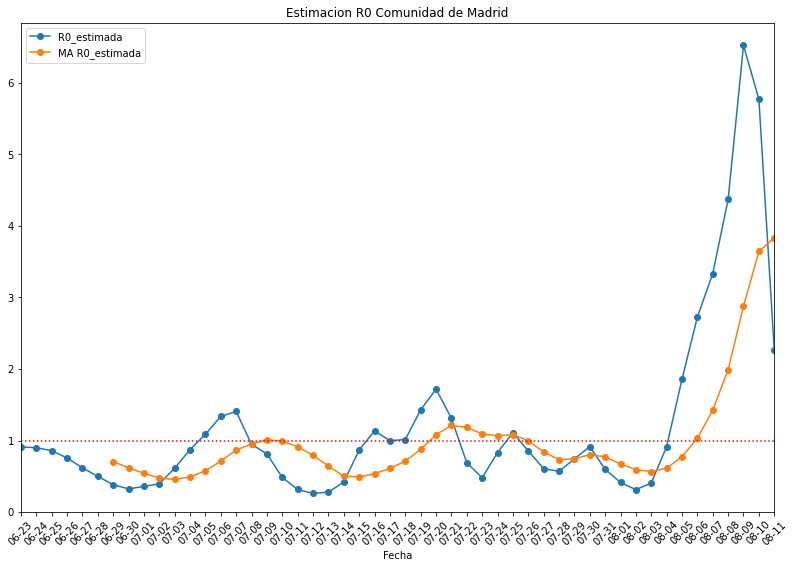

,R0_estimada,MA R0_estimada
Fecha,,
2020-08-11 00:00:00,2.273,3.836
2020-08-10 00:00:00,5.771,3.643
2020-08-09 00:00:00,6.522,2.876
2020-08-08 00:00:00,4.370,1.990
2020-08-07 00:00:00,3.333,1.425
2020-08-06 00:00:00,2.727,1.034
2020-08-05 00:00:00,1.858,0.776
2020-08-04 00:00:00,0.917,0.617
2020-08-03 00:00:00,0.408,0.567


In [8]:
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

df = df_master

def calcular_estimaciones_R0(df):
    def calcular_R0_dia(dia,df):
        dia_semana_anterior = dia - timedelta(days=7)
        return dia,df.loc[dia:dia - timedelta(days=6)]['FALLECIDOS TOTALES hoy'].sum() / df.loc[dia- timedelta(days=7):dia - timedelta(days=13)]['FALLECIDOS TOTALES hoy'].sum() 

    VENTANA_MEDIA_MOVIL=7
    
    df_R0_estimada = pd.DataFrame([calcular_R0_dia(dia,df) for dia in df.index[0:50]],columns=['Fecha','R0_estimada'])
    
    df_R0_estimada = df_R0_estimada.sort_values(by=['Fecha'], ascending=True)
    df_R0_estimada['MA R0_estimada'] = df_R0_estimada['R0_estimada'].rolling(window=VENTANA_MEDIA_MOVIL).mean()
    df_R0_estimada = df_R0_estimada.sort_values(by=['Fecha'], ascending=False)
    df_R0_estimada.set_index('Fecha', inplace=True, drop=True)
    return df_R0_estimada

df= calcular_estimaciones_R0(df_master)
#df=df[['R0_estimada']]
df

chart_df=df[df.columns[-3:]]
chart_df.plot(legend=True,figsize=(13.5,9), marker='o')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45)

ax = plt.gca()
ax.axhline(1, color='r',linestyle =  ':' ) 


ax.set_title("Estimacion R0 Comunidad de Madrid")
ax.set_ylim(ymin=0)

plt.show()

df.style.format ({ c : "{:20,.3f}" for c in df.columns }).background_gradient(cmap='Wistia', )



In [9]:
R0_estimada * 1.2

2.7272727272727275

In [10]:
HTML("<h2>Gráfico muertes diarias en Madrid, según Comunidad de Madrid </h2>")    


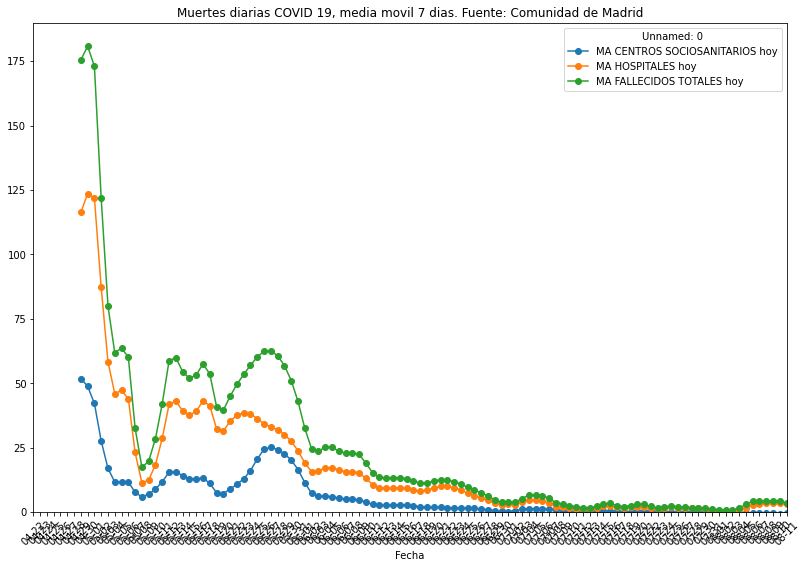

In [11]:
import pandas as pd
import io
import matplotlib.dates as mdates
from matplotlib import pyplot as plt

df = df_master
chart_df=df[df.columns[-3:]]
chart_df.plot(legend=True,figsize=(13.5,9), marker='o')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45)

ax = plt.gca()

ax.set_title("Muertes diarias COVID 19, media movil "+str(VENTANA_MEDIA_MOVIL)+" dias. Fuente: Comunidad de Madrid")
ax.set_ylim(ymin=0)

plt.show()



In [12]:
 from IPython.display import display, HTML
HTML("<h2>Comparamos los datos de hoy, de hace una semana y de un mes </h2>")    

In [13]:


from matplotlib import colors

def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

df = df_master

df.style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia', subset= df.columns[-3:] )



Unnamed: 0,HOSPITALES,DOMICILIOS,CENTROS SOCIOSANITARIOS,OTROS LUGARES,FALLECIDOS TOTALES,HOSPITALES hoy,CENTROS SOCIOSANITARIOS hoy,FALLECIDOS TOTALES hoy,MA CENTROS SOCIOSANITARIOS hoy,MA HOSPITALES hoy,MA FALLECIDOS TOTALES hoy
Fecha,,,,,,,,,,,
2020-08-11 00:00:00,"9,444",935,"4,826",29,"15,234",-1,-0,-1,-0,3,4
2020-08-10 00:00:00,"9,445",935,"4,826",29,"15,235",0,-0,0,-1,4,4
2020-08-09 00:00:00,"9,445",935,"4,826",29,"15,234",1,0,1,-0,4,5
2020-08-08 00:00:00,"9,444",935,"4,826",29,"15,234",2,0,2,-0,3,4
2020-08-07 00:00:00,"9,442",935,"4,826",29,"15,232",3,0,3,-0,3,4
2020-08-06 00:00:00,"9,439",935,"4,826",29,"15,229",8,-1,9,-0,3,4
2020-08-05 00:00:00,"9,431",932,"4,827",29,"15,220",8,-2,11,-0,2,3
2020-08-04 00:00:00,"9,423",929,"4,829",28,"15,209",4,-1,6,0,0,2
2020-08-03 00:00:00,"9,419",927,"4,830",28,"15,203",0,0,1,0,-0,1


In [14]:
df = df_master
pd.concat([df.head(1).tail(1) , df.head(8).tail(1) , df.head(30).tail(1)]).astype(int)[['MA HOSPITALES hoy','MA CENTROS SOCIOSANITARIOS hoy','MA FALLECIDOS TOTALES hoy']].style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia', subset= df.columns[-3:] )

Unnamed: 0,MA HOSPITALES hoy,MA CENTROS SOCIOSANITARIOS hoy,MA FALLECIDOS TOTALES hoy
Fecha,,,
2020-08-11 00:00:00,3,0,3
2020-08-04 00:00:00,0,0,1
2020-07-13 00:00:00,1,0,1


In [15]:
from IPython.display import display, HTML
HTML("<h2>Muertes medias diarias, últimos 7 días, con datos</h2>")

In [16]:

from datetime import date

df = df_master
inicio_crisis = df.head(7).index[6]
df=df.head(7)
dia_mas_reciente = df.index[0]
dias_transcurridos_inicio_crisis = dia_mas_reciente - inicio_crisis
df = pd.DataFrame((df.head(1).max(axis=0) - df.tail(1).max(axis=0) ) /  dias_transcurridos_inicio_crisis.days  ).T[['HOSPITALES','DOMICILIOS','CENTROS SOCIOSANITARIOS','OTROS LUGARES','FALLECIDOS TOTALES']]
df.style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia'  )
  


Unnamed: 0,HOSPITALES,DOMICILIOS,CENTROS SOCIOSANITARIOS,OTROS LUGARES,FALLECIDOS TOTALES
0,2,0,-0,0,2


In [17]:
HTML("<h2>Muertes medias diarias desde que la comunidad de Madrid publica datos</h2>")

In [18]:
# Calculamos los incrementos medios, desde que tenemos fechas
df = df_master
df = pd.DataFrame((df.head(1).max(axis=0) - df.tail(1).max(axis=0) ) / df.shape[0] ).T[['HOSPITALES','DOMICILIOS','CENTROS SOCIOSANITARIOS','OTROS LUGARES','FALLECIDOS TOTALES']]
df.style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia'  )

Unnamed: 0,HOSPITALES,DOMICILIOS,CENTROS SOCIOSANITARIOS,OTROS LUGARES,FALLECIDOS TOTALES
0,21,2,8,0,30
